In [4]:
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

In [5]:
dataset_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder'

In [3]:
def calculate_mean_std(dataset_path, batch_size=32):
    # Add resizing to ensure consistent image dimensions
    transform = transforms.Compose([
        transforms.Resize((299, 299)), 
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    total_sum = torch.zeros(3)
    total_squared_sum = torch.zeros(3)
    total_count = 0
    
    for inputs, _ in loader:
        # Flatten image batch 
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        total_sum += inputs.sum(dim=(0, 2))
        total_squared_sum += (inputs ** 2).sum(dim=(0, 2))
        total_count += inputs.size(0) * inputs.size(2)  
    

    mean = total_sum / total_count
    std = torch.sqrt((total_squared_sum / total_count) - (mean ** 2))
    
    return mean.tolist(), std.tolist()

 
mean, std = calculate_mean_std(os.path.join(dataset_path, 'train'))
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.5000829696655273, 0.45570850372314453, 0.4074460566043854]
Std: [0.27772489190101624, 0.2667883336544037, 0.27002647519111633]


In [6]:
mean= [0.5000829696655273, 0.45570850372314453, 0.4074460566043854]
std= [0.27772489190101624, 0.2667883336544037, 0.27002647519111633]

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=299, scale=(0.875, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
'''
test_transform = transforms.Compose([
    transforms.Resize(320),  
    
    transforms.TenCrop(size=299),  
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize(mean, std)(transforms.ToTensor()(crop)) for crop in crops
    ]))
])
'''
test_transform = transforms.Compose([
    transforms.Resize(299),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [8]:
train_data = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform = test_transform)
val_data = datasets.ImageFolder(os.path.join(dataset_path, 'valid'), transform = test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 64, shuffle= True, pin_memory= False)
test_loader = DataLoader(test_data,
                         batch_size= 64, shuffle= False, pin_memory= False)
val_loader = DataLoader(val_data,
                         batch_size= 64, shuffle= False, pin_memory= False)
classes = ['Angry','Sad','happy','Other']
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')
print(f'Number of vaidation images: {len(val_data)}')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

['Angry', 'Other', 'Sad', 'happy']
Number of train images: 1000
Number of test images: 38
Number of vaidation images: 36
Available processor cuda


In [9]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [10]:
class InceptionA(nn.Module):
    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [11]:
class ReductionA(nn.Module): 
    def __init__(self, in_channels):
        super(ReductionA, self).__init__()
        self.branch3x3 = BasicConv2d(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [12]:
class InceptionB(nn.Module):
    def __init__(self, in_channels, channels_7x7):
        super(InceptionB, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = BasicConv2d(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = BasicConv2d(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = BasicConv2d(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = BasicConv2d(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = BasicConv2d(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)

In [13]:
class ReductionB(nn.Module):  
    def __init__(self, in_channels):
        super(ReductionB, self).__init__()
        self.branch3x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = BasicConv2d(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = BasicConv2d(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = BasicConv2d(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = BasicConv2d(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = BasicConv2d(192, 192, kernel_size=3, stride=2)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return torch.cat(outputs, 1)

In [14]:
class InceptionC(nn.Module):  
    def __init__(self, in_channels):
        super(InceptionC, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = BasicConv2d(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = BasicConv2d(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = BasicConv2d(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = BasicConv2d(in_channels, 192, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [15]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv0 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv1 = BasicConv2d(128, 768, kernel_size=5)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        # B x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # B x 768 x 5 x 5
        x = self.conv0(x)
        # B x 128 x 5 x 5
        x = self.conv1(x)
        # B x 768 x 1 x 1
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # B x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # B x 768
        x = self.fc(x)
        # B x 4
        return x

In [16]:
class MyInceptionV3(nn.Module):
    def __init__(self, num_classes=4):
        super(MyInceptionV3, self).__init__()
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        self.Mixed_6a = ReductionA(288)  
        self.Mixed_6b = InceptionB(768, channels_7x7=128)
        self.Mixed_6c = InceptionB(768, channels_7x7=160)
        self.Mixed_6d = InceptionB(768, channels_7x7=160)
        self.Mixed_6e = InceptionB(768, channels_7x7=192)
        self.AuxLogits = InceptionAux(768, num_classes)
        self.Mixed_7a = ReductionB(768)
        self.Mixed_7b = InceptionC(1280) 
        self.Mixed_7c = InceptionC(2048)  
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        # B x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # B x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # B x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # B x 64 x 147 x 147
        x = self.maxpool1(x)
        # B x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # B x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # B x 192 x 71 x 71
        x = self.maxpool2(x)
        # B x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # B x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # B x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # B x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # B x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # B x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # B x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # B x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # B x 768 x 17 x 17
        aux = self.AuxLogits(x)
        # B x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # B x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # B x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # B x 2048 x 8 x 8
        x = self.avgpool(x)
        # B x 2048 x 1 x 1
        x = self.dropout(x)
        # B x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # B x 2048
        x = self.fc(x)
        # B x 4
        return x, aux
        

In [14]:
num_epochs = 10
batch_size = 16
learning_rate = 0.0001


model = MyInceptionV3().to(device)
model.train()  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/10], Step [10/16], Loss: 1.3886
Epoch [1/10] Training Completed. Loss: 1.4290, Accuracy: 26.50%
Epoch [1/10] Validation Completed. Loss: 1.9606, Accuracy: 25.00%
Epoch [2/10], Step [10/16], Loss: 1.3331
Epoch [2/10] Training Completed. Loss: 1.3938, Accuracy: 31.80%
Epoch [2/10] Validation Completed. Loss: 2.0124, Accuracy: 25.00%
Epoch [3/10], Step [10/16], Loss: 1.3195
Epoch [3/10] Training Completed. Loss: 1.3481, Accuracy: 36.30%
Epoch [3/10] Validation Completed. Loss: 1.8869, Accuracy: 36.11%
Epoch [4/10], Step [10/16], Loss: 1.2237
Epoch [4/10] Training Completed. Loss: 1.3318, Accuracy: 37.90%
Epoch [4/10] Validation Completed. Loss: 2.0732, Accuracy: 30.56%
Epoch [5/10], Step [10/16], Loss: 1.3041
Epoch [5/10] Training Completed. Loss: 1.3101, Accuracy: 41.60%
Epoch [5/10] Validation Completed. Loss: 2.2513, Accuracy: 27.78%
Epoch [6/10], Step [10/16], Loss: 1.4601
Epoch [6/10] Training Completed. Loss: 1.2874, Accuracy: 39.30%
Epoch [6/10] Validation Completed. Loss:

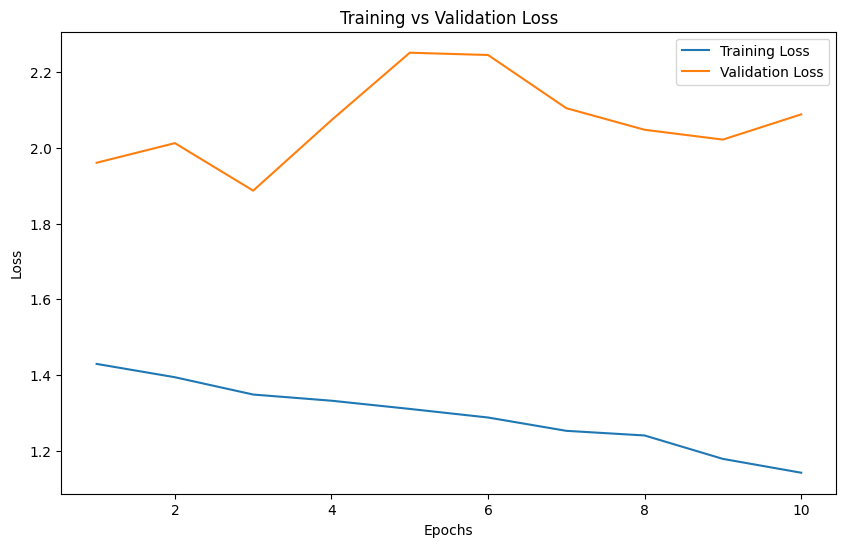

In [15]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  
    total_correct = 0
    total_samples = 0
    running_loss = 0.0
    if epoch % 3 == 0:
        learning_rate = learning_rate / 10
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs, aux_outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_accuracy = (total_correct / total_samples) * 100
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] Training Completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    model.eval()  
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs, aux_outputs = model(images)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2 

            _, predicted = torch.max(outputs, 1)
            val_total_correct += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = (val_total_correct / val_total_samples) * 100
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Completed. Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

print('Training complete.')


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Accuracy: 34.21%
Mean Precision: 0.32
Mean Recall: 0.33
Mean F1-score: 0.32

Confusion Matrix:
[[5 2 1 2]
 [2 1 1 2]
 [4 1 2 4]
 [3 0 3 5]]


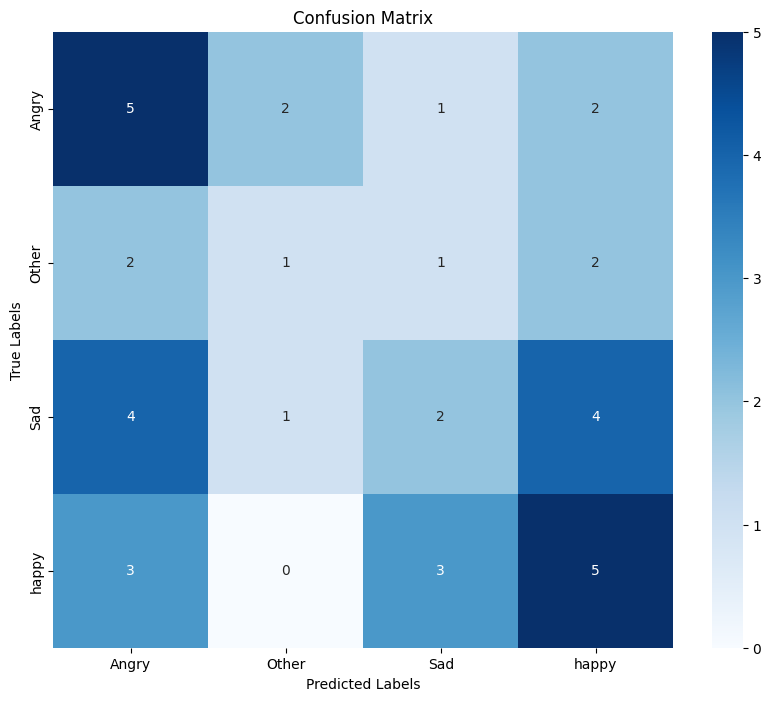

In [17]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad(): 
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = model(images)  
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = np.mean(all_predictions == all_labels) * 100

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_report = classification_report(
    all_labels, 
    all_predictions, 
    target_names=class_names,  
    output_dict=True
)


mean_precision = np.mean([v['precision'] for k, v in class_report.items() if k != 'accuracy'])
mean_recall = np.mean([v['recall'] for k, v in class_report.items() if k != 'accuracy'])
mean_f1 = np.mean([v['f1-score'] for k, v in class_report.items() if k != 'accuracy'])


print(f'Accuracy: {accuracy:.2f}%')
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-score: {mean_f1:.2f}')
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
pretrained_model = models.inception_v3(pretrained=True)
total_params = sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_params}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 95.2MB/s] 


Total learnable parameters: 27161264


In [19]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_params}")

Total learnable parameters: 24354536


In [20]:
custom_model = MyInceptionV3()

In [21]:
def transfer_weights(pretrained_model, custom_model):
    pretrained_layers = [layer for layer in pretrained_model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.Linear))]
    custom_layers = [layer for layer in custom_model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.Linear))]

    for pretrained_layer, custom_layer in zip(pretrained_layers, custom_layers):
        # Check same type and shape
        if isinstance(pretrained_layer, type(custom_layer)) and pretrained_layer.weight.size() == custom_layer.weight.size():
            custom_layer.weight.data.copy_(pretrained_layer.weight.data)
            if hasattr(pretrained_layer, 'bias') and hasattr(custom_layer, 'bias'):
                if pretrained_layer.bias is not None and custom_layer.bias is not None:
                    custom_layer.bias.data.copy_(pretrained_layer.bias.data)
        else:
            print(f"Skipping incompatible layers: {pretrained_layer} -> {custom_layer}")


transfer_weights(pretrained_model, custom_model)

print("Weights transferred successfully!")

Skipping incompatible layers: Linear(in_features=768, out_features=1000, bias=True) -> Linear(in_features=768, out_features=4, bias=True)
Skipping incompatible layers: Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=4, bias=True)
Weights transferred successfully!


In [17]:
pretrained_model = models.inception_v3(pretrained=True)

pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 4)

if pretrained_model.AuxLogits is not None:
    pretrained_model.AuxLogits.fc = nn.Linear(pretrained_model.AuxLogits.fc.in_features, 4)

pretrained_model = pretrained_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 99.6MB/s] 


In [18]:
num_epochs = 7
batch_size = 16
learning_rate = 1e-4


pretrained_model.train()  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=learning_rate)

In [20]:
model = pretrained_model

Epoch [1/7], Train Loss: 1.7286, Validation Loss: 1.2057, Train Accuracy: 44.40%, Validation Accuracy: 41.67%
Epoch [2/7], Train Loss: 1.1582, Validation Loss: 1.2956, Train Accuracy: 69.70%, Validation Accuracy: 41.67%
Epoch [3/7], Train Loss: 0.6563, Validation Loss: 1.3452, Train Accuracy: 89.10%, Validation Accuracy: 41.67%
Epoch [4/7], Train Loss: 0.3386, Validation Loss: 1.5008, Train Accuracy: 95.90%, Validation Accuracy: 50.00%
Epoch [5/7], Train Loss: 0.1622, Validation Loss: 1.7239, Train Accuracy: 99.10%, Validation Accuracy: 44.44%
Epoch [6/7], Train Loss: 0.0882, Validation Loss: 1.8385, Train Accuracy: 99.50%, Validation Accuracy: 47.22%
Epoch [7/7], Train Loss: 0.0764, Validation Loss: 2.1229, Train Accuracy: 99.50%, Validation Accuracy: 47.22%


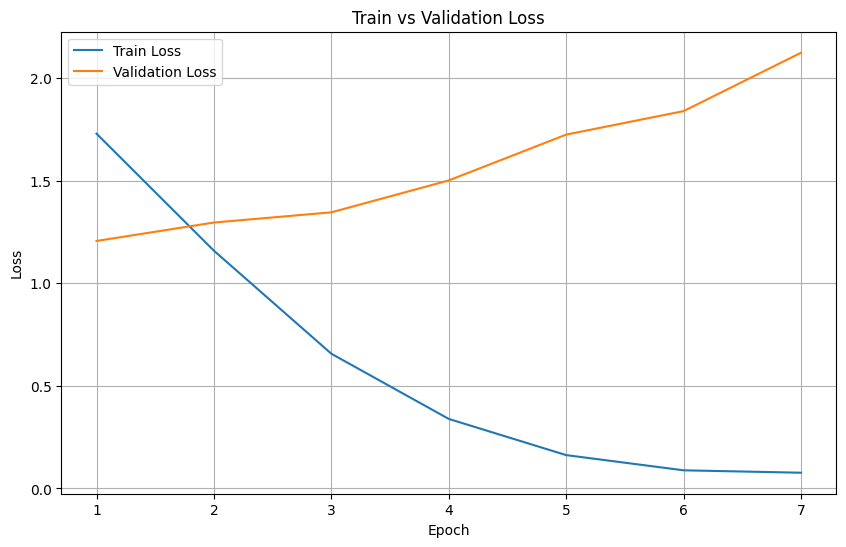

Training complete.


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    pretrained_model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    if epoch % 3 == 0:
        learning_rate = learning_rate / 10
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs, aux_outputs = pretrained_model(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # Combine losses (weight for aux_outputs is 0.4)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Intermediate logging
        if (i + 1) % 32 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Calculate epoch-level training metrics
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    pretrained_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs= pretrained_model(inputs)  # Ignore aux_outputs during validation
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate epoch-level validation metrics
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

print('Training complete.')

In [22]:
pretrained_model.eval()

all_labels = []
all_predictions = []

with torch.no_grad(): 
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = pretrained_model(images)  
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = np.mean(all_predictions == all_labels) * 100

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_report = classification_report(
    all_labels, 
    all_predictions, 
    target_names=class_names,  
    output_dict=True
)


mean_precision = np.mean([v['precision'] for k, v in class_report.items() if k != 'accuracy'])
mean_recall = np.mean([v['recall'] for k, v in class_report.items() if k != 'accuracy'])
mean_f1 = np.mean([v['f1-score'] for k, v in class_report.items() if k != 'accuracy'])


print(f'Accuracy: {accuracy:.2f}%')
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-score: {mean_f1:.2f}')
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 52.63%
Mean Precision: 0.44
Mean Recall: 0.48
Mean F1-score: 0.45

Confusion Matrix:
[[8 1 0 1]
 [2 0 3 1]
 [3 0 7 1]
 [3 1 2 5]]
